In [ ]:
## colab stuffs
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/Shareddrives/TESI SOSTEGNI/physioex

In [ ]:
!pip install --upgrade pip
!pip install -e .

In [3]:
import os
from loguru import logger

# computing library
import numpy as np
import pandas as pd
import torch  # dedicated to neural networks, allow for gradient computation

from scipy import signal

# progress bar
from tqdm import tqdm

# explanations algorithms
from captum.attr import IntegratedGradients
from physioex.explain.spectralgradients import SpectralGradients

# dataset
from physioex.data import TimeDistributedModule, Dreem, set_data_folder

# neural networks
from physioex.models import load_pretrained_model
from physioex.train.networks import config as networks


# plotting library
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_lightning import seed_everything

torch.backends.cudnn.enabled = False

seed_everything(42)

Seed set to 42


42

In [4]:
# constant definitno

device = "cuda" if torch.cuda.is_available() else "cpu"

sequence_lenght = 21
picks = ["EEG"]
fold = 0
batch_size = 32

model_name = "tinysleepnet"

In [5]:
# load model
model = load_pretrained_model(
    name=model_name,
    sequence_length=sequence_lenght,
    in_channels=len(picks),
    device="cpu",
    softmax=False,
).eval()  # chambon is a MISO model, predicts the class of the central epoch

# change it with your data path
set_data_folder("/content/drive/Shareddrives/TESI SOSTEGNI/data/")

# load data
dataset = Dreem(
    version="dodh",
    picks=picks,
    sequence_length=sequence_lenght,
    target_transform=networks[model_name]["target_transform"],
    preprocessing=networks[model_name]["input_transform"],
)

dataset = TimeDistributedModule(dataset=dataset, batch_size=batch_size, fold=fold)


train_loader, valid_loader, test_loader = (
    dataset.train_dataloader(),
    dataset.val_dataloader(),
    dataset.test_dataloader(),
)

/home/guido/shared/github/physioex-private/physioex/models/load.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["sequence_length"] == sequence_length]
/home/guido/shared/github/physioex-private/physioex/models/load.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["in_channels"] == in_channels]
/home/guido/shared/github/physioex-private/physioex/models/load.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["loss"] == loss]
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'nn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nn'])`.
2024-07-10 08:54:27.109 | INFO     | physioex.data.constant:set_data_folder:25 - Da

In [6]:
# test your model
model = model.to(device)

y_true, y_pred, pred_probas = [], [], []

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # Calcola le previsioni del modello

        batch_preds = model(inputs.to(device)).cpu().detach()

        batch_preds = batch_preds.view(-1, 5)
        labels = labels.view(-1)

        pred_probas.extend(batch_preds)
        y_pred.extend(torch.argmax(batch_preds, dim=1))
        y_true.extend(labels)

model = model.to("cpu")

y_true = torch.stack(y_true).numpy()
y_pred = torch.stack(y_pred).numpy()
pred_probas = torch.stack(pred_probas).numpy()

100%|██████████| 89/89 [00:12<00:00,  7.30it/s]


<Axes: >

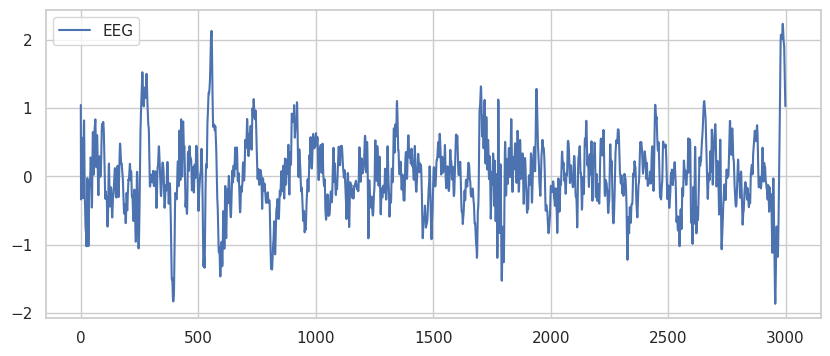

In [9]:
# plot input data
plt.figure(figsize=(10, 4))

sns.lineplot(data=inputs[21, 0, 0, :].numpy(), label="EEG")

Accuracy: 72.85%


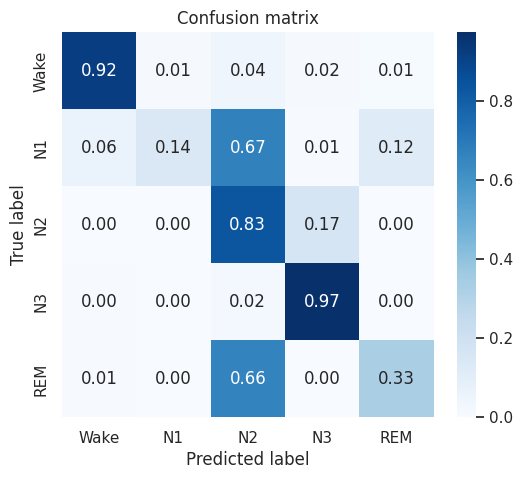

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

conf_mat_norm = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Wake", "N1", "N2", "N3", "REM"],
    yticklabels=["Wake", "N1", "N2", "N3", "REM"],
)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [16]:
exp_batch_size = 1000

# randomly select 1000 from the dataset
indices = np.random.choice(len(dataset.dataset), exp_batch_size, replace=False)

exp_batch = []

for indx in tqdm(indices):
    exp_batch.append(dataset.dataset[indx])

100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]
